In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse the RBS data from Borujeni 2016

Still thank you ScienceMachine :) 

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import re
from common import count_ARN_motifs, count_AAN_motifs


fn = os.path.join('data', 'RBSCalculatorData.xlsx')
top_dir = os.path.join('data', '20_analyse_RBS_data_Borujeni')
name_sheet = 'Broujeni 2016'

In [38]:
# Read the Excel file
excel_file = pd.ExcelFile(fn)

# Read the Broujeni 2016 sheet
df = excel_file.parse(name_sheet)

# Display the column names
print("Column names:")
print(df.columns.tolist())
print("\nShape of dataframe:", df.shape)

Column names:
['Delta G', 'TIR (AU)', 'Ln TIR', 'Fluorescence', 'Ln Fluorescence', 'Model Error (Fluorescence/TIR)', 'Sequence', 'Paper', 'Curated By']

Shape of dataframe: (485, 9)


# Add the ARN motif


In [40]:
# Count motifs in each sequence
df['ARN_count'] = df['Sequence'].apply(count_ARN_motifs)
df['AAN_count'] = df['Sequence'].apply(count_AAN_motifs)

# Get total count across all sequences
total_ARN_count = df['ARN_count'].sum()
total_AAN_count = df['AAN_count'].sum()

print(f"Total number of ARN motifs across all sequences: {total_ARN_count}")
print(f"Total number of AAN motifs across all sequences: {total_AAN_count}")
print(f"\nNumber of sequences analyzed: {len(df)}")
print(f"Average ARN motifs per sequence: {total_ARN_count / len(df):.2f}")
print(f"Average AAN motifs per sequence: {total_AAN_count / len(df):.2f}")

# Show distribution of ARN counts
print("\nDistribution of ARN motifs per sequence:")
print(df['ARN_count'].value_counts().sort_index())

# Show distribution of AAN counts
print("\nDistribution of AAN motifs per sequence:")
print(df['AAN_count'].value_counts().sort_index())

Total number of ARN motifs across all sequences: 2949
Total number of AAN motifs across all sequences: 1728

Number of sequences analyzed: 485
Average ARN motifs per sequence: 6.08
Average AAN motifs per sequence: 3.56

Distribution of ARN motifs per sequence:
ARN_count
2      7
3     65
4     88
5     73
6     73
7     64
8     40
9     24
10    20
11     9
12    10
13     7
14     2
18     1
20     1
25     1
Name: count, dtype: int64

Distribution of AAN motifs per sequence:
AAN_count
0       8
1      40
2     154
3      80
4      82
5      44
6      31
7      17
8      12
9       8
10      3
11      2
12      1
16      1
17      1
22      1
Name: count, dtype: int64


In [41]:
# Let's examine a few sequences and their ARN motifs
print("Examples of ARN motifs found in sequences:\n")

# Take first 3 sequences as examples
for i in range(3):
    sequence = df.iloc[i]['Sequence']
    pattern = r'A[AG][ACGT]'
    matches = re.findall(pattern, sequence.upper())
    
    print(f"Sequence {i+1} (first 50 chars): {sequence[:50]}...")
    print(f"ARN motifs found: {matches}")
    print(f"Count: {len(matches)}\n")

# Also check which specific ARN patterns are most common
print("\nBreakdown of specific ARN patterns found:")
all_matches = []
for sequence in df['Sequence']:
    matches = re.findall(r'A[AG][ACGT]', sequence.upper())
    all_matches.extend(matches)

from collections import Counter
pattern_counts = Counter(all_matches)
for pattern, count in sorted(pattern_counts.items(), key=lambda x: -x[1]):
    print(f"{pattern}: {count} occurrences")

Examples of ARN motifs found in sequences:

Sequence 1 (first 50 chars): TTCTAGATTAGGCCTGATCTAAGCCATTAACTTTAGTT...
ARN motifs found: ['AGA', 'AGG', 'AAG', 'AAC', 'AGT']
Count: 5

Sequence 2 (first 50 chars): TTCTAGACCAGTCGCGTACCGCTATTGGTCCAGCTACAATGGCTGAAGCG...
ARN motifs found: ['AGA', 'AGT', 'AGC', 'AAT', 'AAG', 'AAA']
Count: 6

Sequence 3 (first 50 chars): TTCTAGATTCTAaaggaggAGTCCGGG...
ARN motifs found: ['AGA', 'AAA', 'AGG', 'AGT']
Count: 4


Breakdown of specific ARN patterns found:
AAA: 723 occurrences
AGA: 574 occurrences
AGG: 494 occurrences
AAG: 433 occurrences
AAC: 336 occurrences
AGC: 178 occurrences
AAT: 149 occurrences
AGT: 62 occurrences


# Plot functions

In [42]:
def plot_scatter(key_motif, key_y):
    motif_type = 'ARN' if key_motif == 'ARN_count' else 'AAN'

    # Set up the plot style
    plt.figure(figsize=(10, 8))
    sns.set_style("whitegrid")

    # Create scatter plot
    plt.scatter(df[key_motif], df[key_y], 
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

    # Calculate correlation
    correlation = df[key_motif].corr(df[key_y])
    pearson_r, p_value = stats.pearsonr(df[key_motif], df[key_y])
    
    # Labels and title
    plt.xlabel(f'Number of {motif_type} Motifs', fontsize=12)
    plt.ylabel(key_y, fontsize=12)
    plt.title(f'Correlation between {motif_type} Motif Count and Predicted {key_y}\n' + 
            f'Pearson r = {correlation:.3f}, p-value = {p_value:.3e}', fontsize=14)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Save and show
    plt.tight_layout()
    key_y_save = key_y.replace(' ', '_').split('(')[0]
    plt.savefig(os.path.join(top_dir, f'{motif_type}_motif_vs_{key_y_save}.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Print additional statistics
    print(f"Correlation coefficient (Pearson r): {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")
    print(f"R-squared: {correlation**2:.4f}")
    print(f"\nLinear regression equation: {key_y} = {z[0]:.3f} × (ARN count) + {z[1]:.3f}")

In [43]:
def plot_boxplot(key_motif, key_y):
    motif_type = 'ARN' if key_motif == 'ARN_count' else 'AAN'
    
    # Create a box plot
    plt.figure(figsize=(12, 8))

    # Create box plot
    box_plot = plt.boxplot([df[df[key_motif] == count][key_y].values 
                            for count in sorted(df[key_motif].unique())],
                        positions=sorted(df[key_motif].unique()),
                        widths=0.6,
                        patch_artist=True,
                        showfliers=True)

    # Customize box plot colors
    for patch in box_plot['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Add median values as text
    for i, count in enumerate(sorted(df[key_motif].unique())):
        median_val = df[df[key_motif] == count][key_y].median()
        n_samples = len(df[df[key_motif] == count])
        plt.text(count, median_val, f'{median_val:.1f}', 
                horizontalalignment='center', verticalalignment='bottom', fontsize=8)
        # Add sample size below x-axis
        plt.text(count, plt.ylim()[0] - 1, f'n={n_samples}', 
                horizontalalignment='center', verticalalignment='top', fontsize=8)

    # Labels and title
    plt.xlabel(f'Number of {motif_type} Motifs', fontsize=12)
    plt.ylabel(key_y, fontsize=12)
    plt.title(f'Distribution of Predicted {key_y} by {motif_type} Motif Count', fontsize=14)

    # Add grid
    plt.grid(True, alpha=0.3, axis='y')

    # Save and show
    plt.tight_layout()
    key_y_save = key_y.replace(' ', '_').split('(')[0]
    plt.savefig(os.path.join(top_dir, f'{motif_type}_motif_vs_{key_y_save}_boxplot.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate and print summary statistics
    print(f"\nSummary statistics by {motif_type} motif count:")
    print(f"{motif_type} Count | n | Mean {key_y} | Median {key_y} | Std Dev")
    print("-" * 55)
    for count in sorted(df[key_motif].unique()):
        subset = df[df[key_motif] == count][key_y]
        print(f"{count:9d} | {len(subset):2d} | {subset.mean():11.2f} | {subset.median():13.2f} | {subset.std():7.2f}")

# ARN motifs correlating with DG


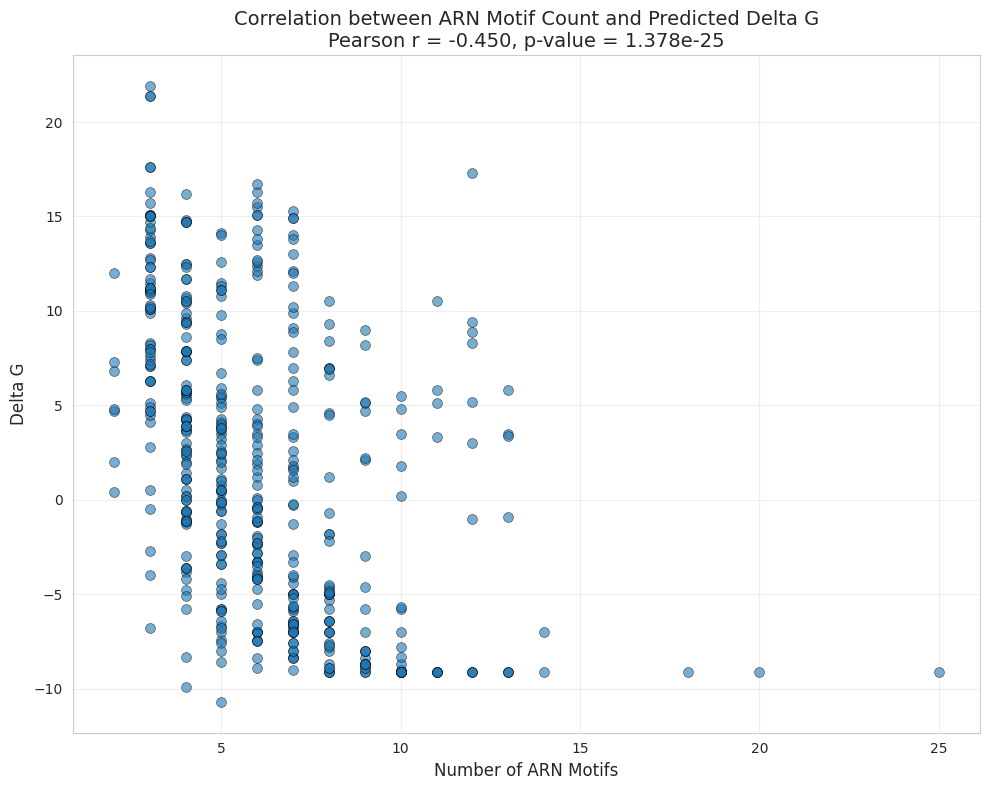

Correlation coefficient (Pearson r): -0.4503
P-value: 1.3784e-25
R-squared: 0.2027

Linear regression equation: Delta G = -1.257 × (ARN count) + 9.413


In [44]:
plot_scatter('ARN_count', 'Delta G')


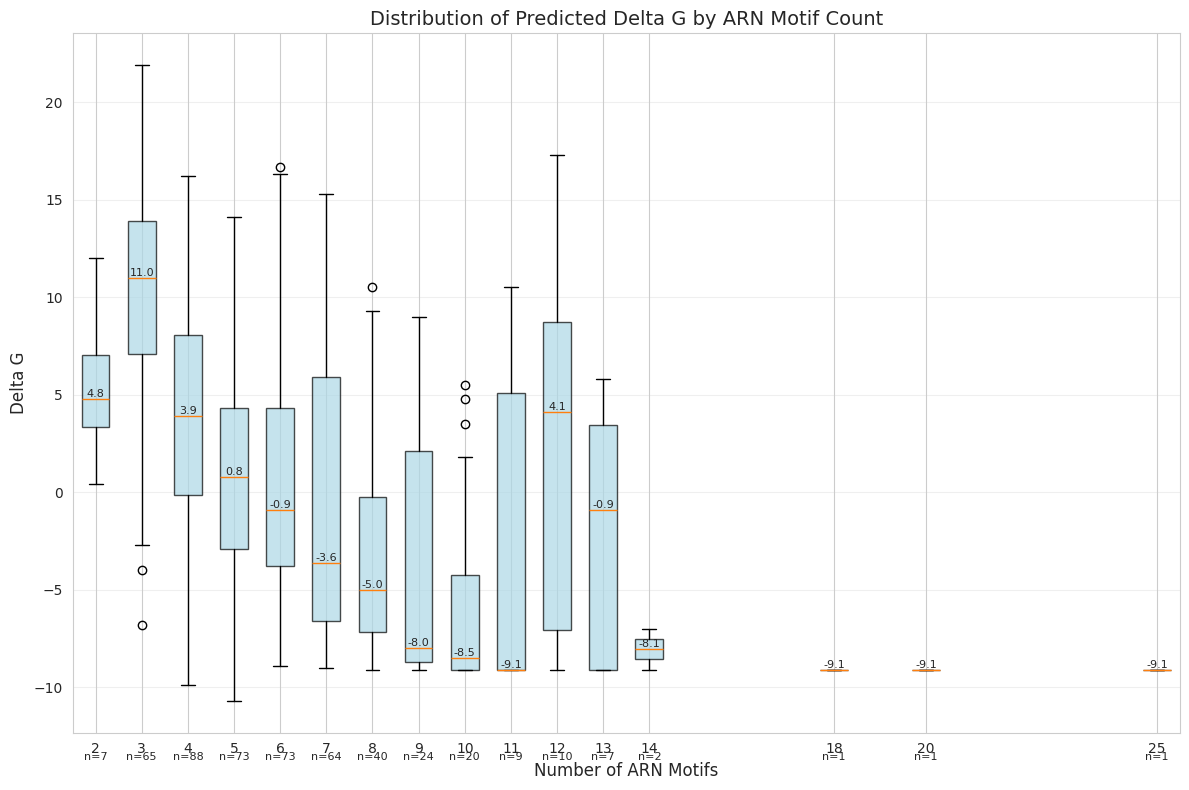


Summary statistics by ARN motif count:
ARN Count | n | Mean Delta G | Median Delta G | Std Dev
-------------------------------------------------------
        2 |  7 |        5.43 |          4.80 |    3.80
        3 | 65 |       10.09 |         11.00 |    5.67
        4 | 88 |        4.12 |          3.90 |    5.70
        5 | 73 |        1.17 |          0.80 |    5.93
        6 | 73 |        1.36 |         -0.90 |    7.26
        7 | 64 |       -0.08 |         -3.65 |    7.65
        8 | 40 |       -2.89 |         -5.00 |    6.04
        9 | 24 |       -3.99 |         -8.00 |    6.35
       10 | 20 |       -5.47 |         -8.50 |    5.31
       11 |  9 |       -2.31 |         -9.10 |    8.27
       12 | 10 |        2.38 |          4.10 |    9.22
       13 |  7 |       -2.21 |         -0.90 |    6.74
       14 |  2 |       -8.05 |         -8.05 |    1.48
       18 |  1 |       -9.10 |         -9.10 |     nan
       20 |  1 |       -9.10 |         -9.10 |     nan
       25 |  1 |       

In [45]:
plot_boxplot('ARN_count', 'Delta G')

# ARN motifs vs. fluorescence

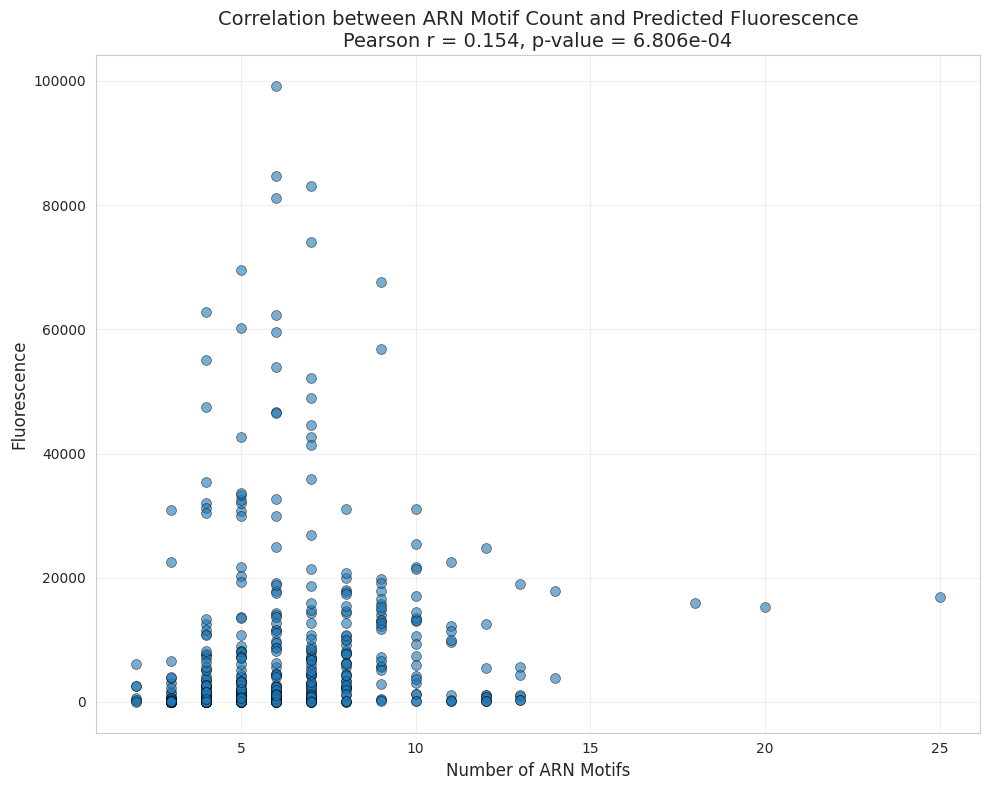

Correlation coefficient (Pearson r): 0.1537
P-value: 6.8059e-04
R-squared: 0.0236

Linear regression equation: Fluorescence = -1.257 × (ARN count) + 9.413


In [46]:
plot_scatter('ARN_count', 'Fluorescence')


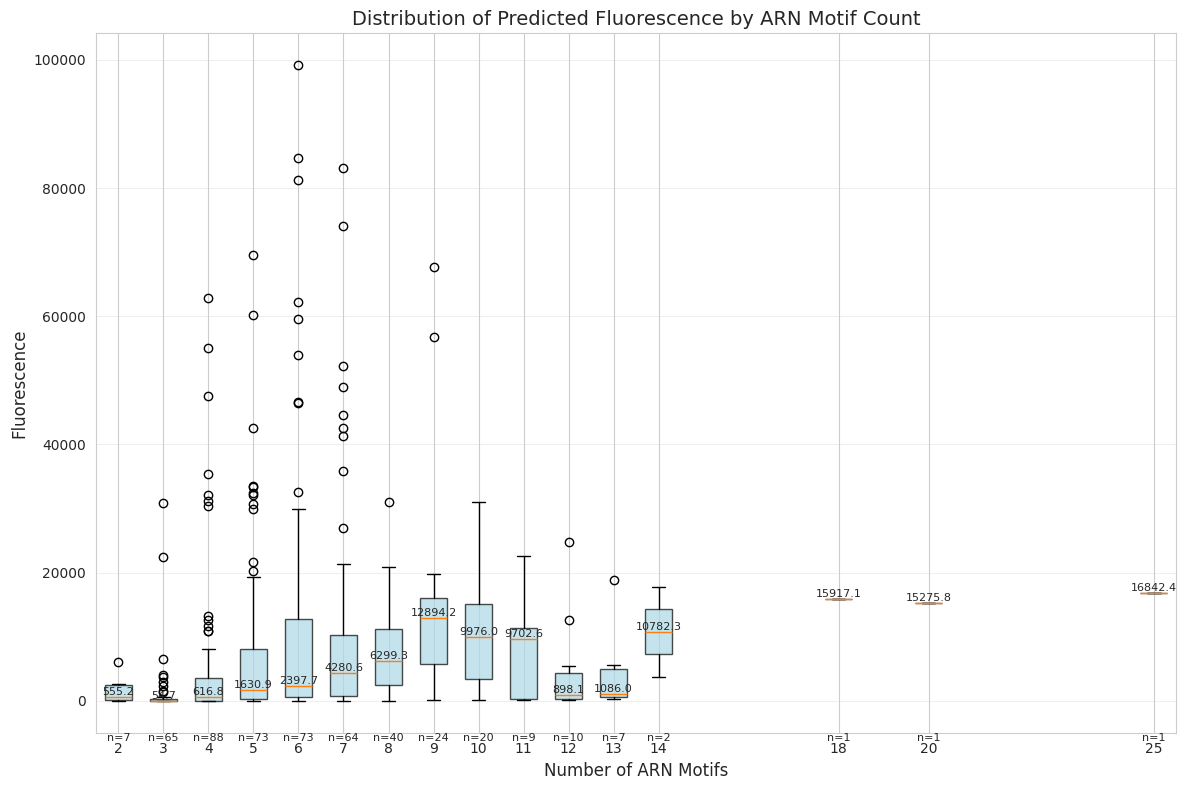


Summary statistics by ARN motif count:
ARN Count | n | Mean Fluorescence | Median Fluorescence | Std Dev
-------------------------------------------------------
        2 |  7 |     1741.18 |        555.22 | 2205.15
        3 | 65 |     1271.28 |         54.67 | 4764.26
        4 | 88 |     5216.97 |        616.77 | 11838.80
        5 | 73 |     7999.45 |       1630.89 | 14013.44
        6 | 73 |    12264.43 |       2397.73 | 21406.46
        7 | 64 |    11010.31 |       4280.59 | 17782.35
        8 | 40 |     8113.17 |       6299.34 | 7040.19
        9 | 24 |    14769.99 |      12894.18 | 15884.83
       10 | 20 |    10873.18 |       9975.98 | 8964.01
       11 |  9 |     7486.07 |       9702.58 | 7718.88
       12 | 10 |     4690.70 |        898.10 | 8083.17
       13 |  7 |     4510.79 |       1086.04 | 6697.92
       14 |  2 |    10782.26 |      10782.26 | 9905.09
       18 |  1 |    15917.14 |      15917.14 |     nan
       20 |  1 |    15275.82 |      15275.82 |     nan
       2

In [47]:
plot_boxplot('ARN_count', 'Fluorescence')


# Now the same but only for motifs that start with "AA"

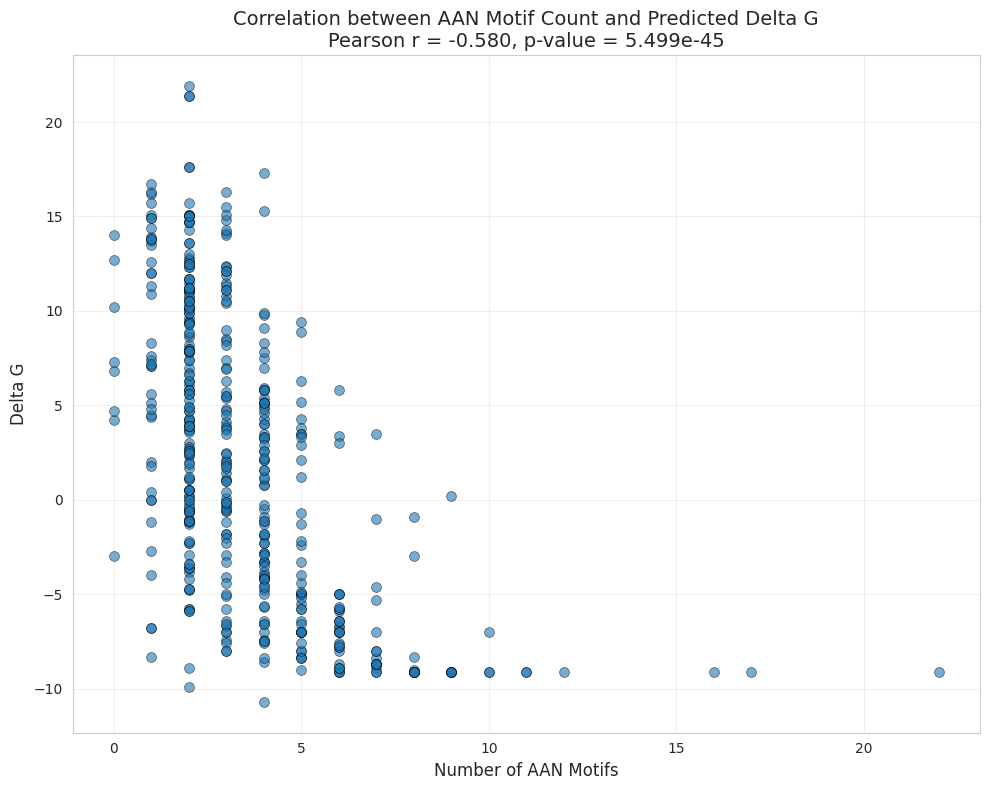

Correlation coefficient (Pearson r): -0.5802
P-value: 5.4988e-45
R-squared: 0.3367

Linear regression equation: Delta G = -1.257 × (ARN count) + 9.413


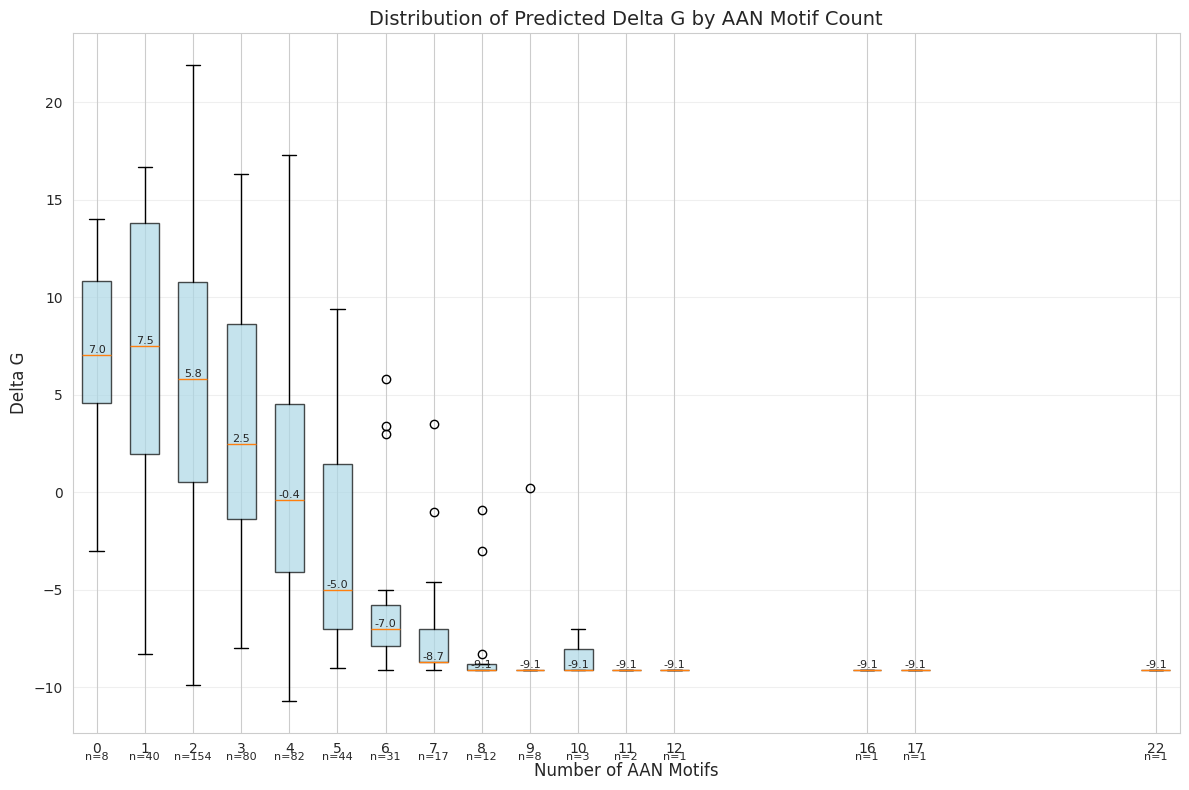


Summary statistics by AAN motif count:
AAN Count | n | Mean Delta G | Median Delta G | Std Dev
-------------------------------------------------------
        0 |  8 |        7.11 |          7.05 |    5.41
        1 | 40 |        7.38 |          7.50 |    7.23
        2 | 154 |        5.77 |          5.80 |    6.57
        3 | 80 |        3.39 |          2.45 |    6.77
        4 | 82 |        0.27 |         -0.40 |    5.60
        5 | 44 |       -2.97 |         -5.00 |    5.15
        6 | 31 |       -6.07 |         -7.00 |    3.63
        7 | 17 |       -6.95 |         -8.70 |    3.43
        8 | 12 |       -7.83 |         -9.10 |    2.79
        9 |  8 |       -7.94 |         -9.10 |    3.29
       10 |  3 |       -8.40 |         -9.10 |    1.21
       11 |  2 |       -9.10 |         -9.10 |    0.00
       12 |  1 |       -9.10 |         -9.10 |     nan
       16 |  1 |       -9.10 |         -9.10 |     nan
       17 |  1 |       -9.10 |         -9.10 |     nan
       22 |  1 |      

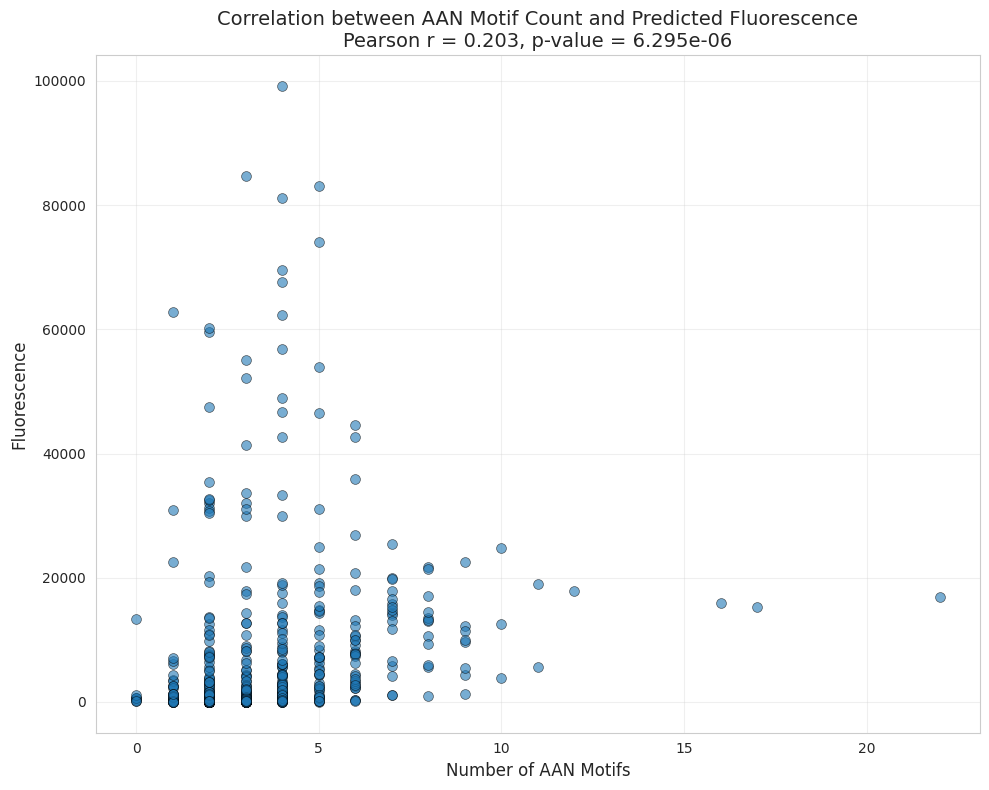

Correlation coefficient (Pearson r): 0.2034
P-value: 6.2950e-06
R-squared: 0.0414

Linear regression equation: Fluorescence = -1.257 × (ARN count) + 9.413


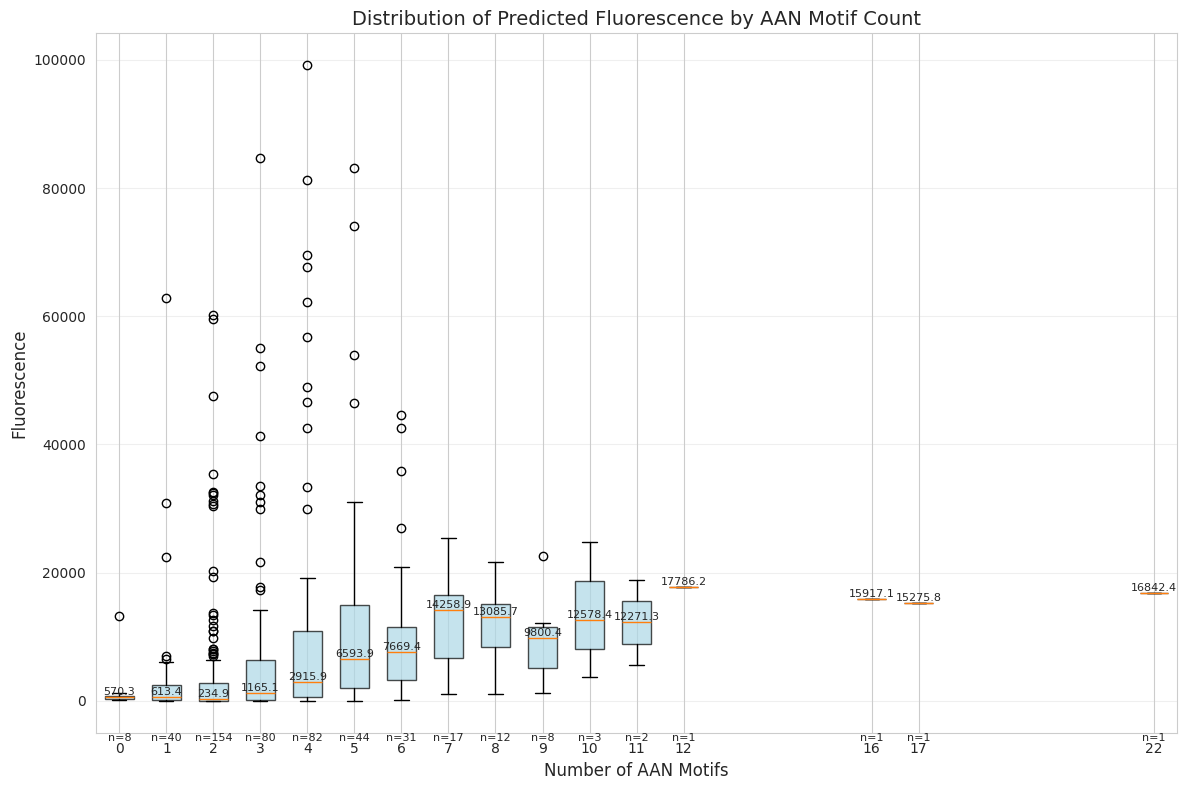


Summary statistics by AAN motif count:
AAN Count | n | Mean Fluorescence | Median Fluorescence | Std Dev
-------------------------------------------------------
        0 |  8 |     2098.25 |        570.33 | 4539.77
        1 | 40 |     4208.88 |        613.39 | 11210.24
        2 | 154 |     4297.05 |        234.87 | 10317.49
        3 | 80 |     7211.18 |       1165.08 | 14574.18
        4 | 82 |    11555.71 |       2915.89 | 20351.92
        5 | 44 |    12895.61 |       6593.87 | 18608.51
        6 | 31 |    10927.86 |       7669.39 | 11752.59
        7 | 17 |    12773.27 |      14258.87 | 6878.67
        8 | 12 |    12228.53 |      13085.74 | 6214.55
        9 |  8 |     9599.63 |       9800.36 | 6468.48
       10 |  3 |    13731.99 |      12578.44 | 10577.74
       11 |  2 |    12271.26 |      12271.26 | 9414.37
       12 |  1 |    17786.22 |      17786.22 |     nan
       16 |  1 |    15917.14 |      15917.14 |     nan
       17 |  1 |    15275.82 |      15275.82 |     nan
     

In [48]:
plot_scatter('AAN_count', 'Delta G')
plot_boxplot('AAN_count', 'Delta G')
plot_scatter('AAN_count', 'Fluorescence')
plot_boxplot('AAN_count', 'Fluorescence')


# ARN vs. ln Fluorescence

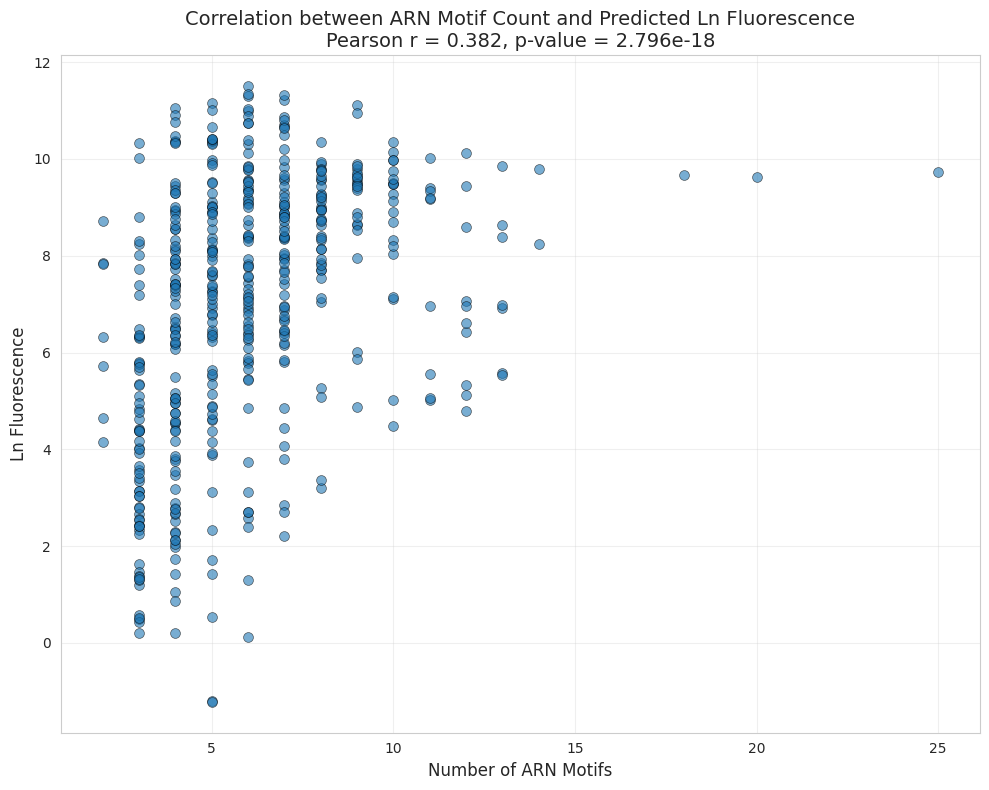

Correlation coefficient (Pearson r): 0.3818
P-value: 2.7961e-18
R-squared: 0.1458

Linear regression equation: Ln Fluorescence = -1.257 × (ARN count) + 9.413


In [52]:
plot_scatter('ARN_count', 'Ln Fluorescence')


# ARN vs. TIR

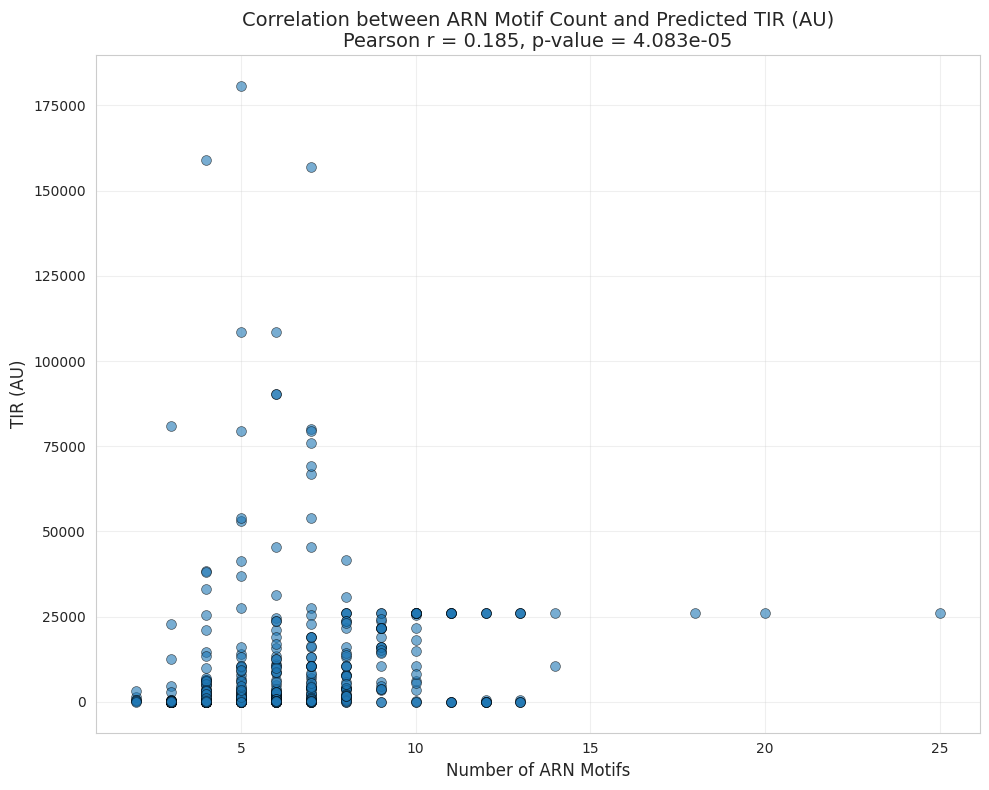

Correlation coefficient (Pearson r): 0.1852
P-value: 4.0826e-05
R-squared: 0.0343

Linear regression equation: TIR (AU) = -1.257 × (ARN count) + 9.413


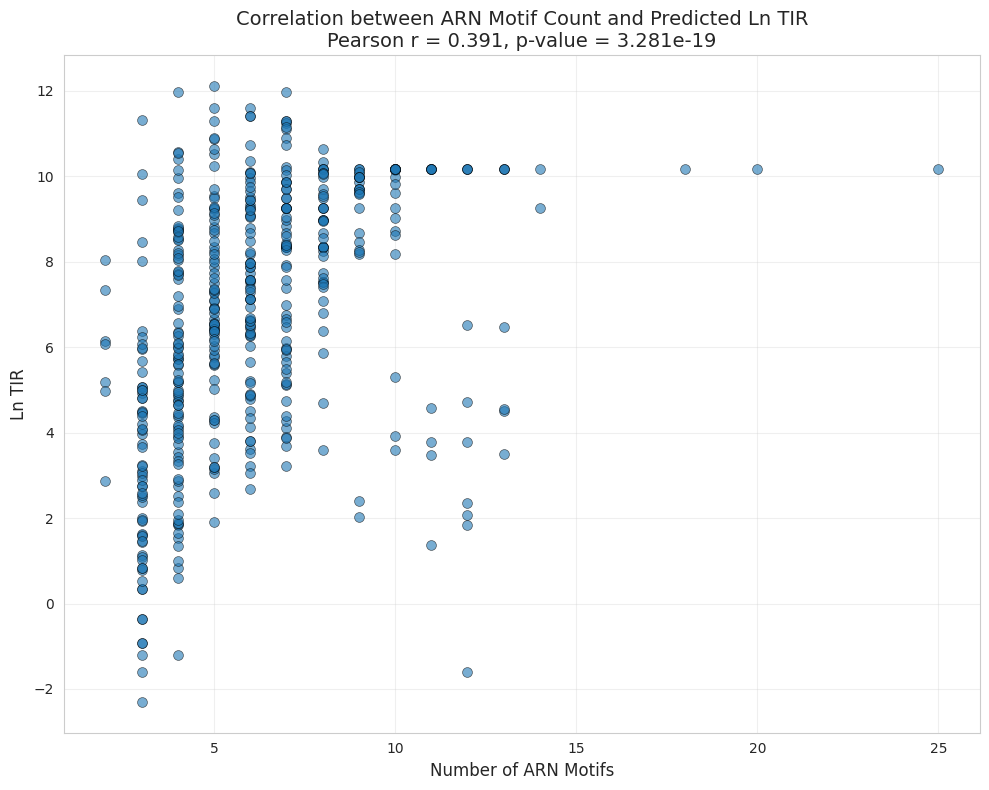

Correlation coefficient (Pearson r): 0.3915
P-value: 3.2805e-19
R-squared: 0.1532

Linear regression equation: Ln TIR = -1.257 × (ARN count) + 9.413


In [51]:
plot_scatter('ARN_count', 'TIR (AU)')
plot_scatter('ARN_count', 'Ln TIR')